In [81]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.preprocessing import LabelEncoder

from stellargraph import globalvar
from stellargraph import datasets
from stellargraph import StellarGraph
from IPython.display import display, HTML
%matplotlib inline

import ast
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [2]:
# retrieving data and putting into pandas dataframe
c_cites = pd.read_csv(
    '../data/cora.cites.csv',
    # sep="\t",
    # header=None,
    names=["target", "source"],
    ) # no column unique
c_cites = c_cites.drop(0)
c_cites['target'] = c_cites['target'].apply(pd.to_numeric)
c_cites['source'] = c_cites['source'].apply(pd.to_numeric)
print(c_cites.head())
print(c_cites.shape)

   target  source
1      35     887
2      35    1033
3      35    1688
4      35    1956
5      35    8865
(5429, 2)


In [75]:
G = StellarGraph(edges=c_cites)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  default: [2708]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [5429]
        Weights: all 1 (default)
        Features: none


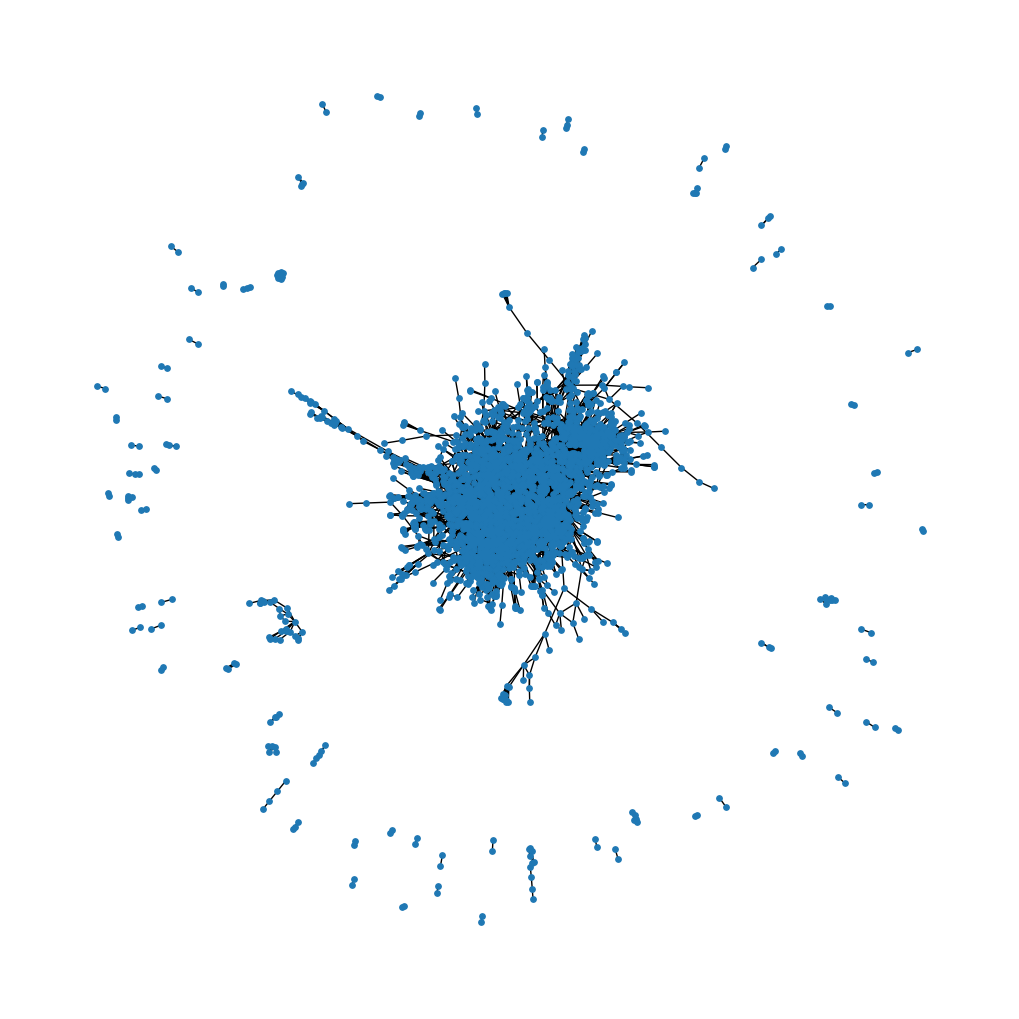

In [8]:
gx = StellarGraph.to_networkx(G)

plt.figure(figsize=(10, 10))
# colors = c_paper["subject"].tolist()
# cora_graph = nx.from_pandas_edgelist(c_cites.sample(n=1500))
# subjects = list(c_paper[c_paper["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(gx, node_size=15) #, node_color=subjects)

In [4]:
def gen():
    with open('../data/outputacm.txt', 'r',  encoding="utf8") as f:
        datum={}
        citations =[]
        row=0
        readFile = f.readlines()
        for line in readFile:
            # if row > 10:
            #     break
            # else:
            #     if line == '\n':
            #         print("New Line!")
            #     print(line)
            #     row = row + 1
            #     continue
            if '#index' in line:
                citations =[]
                datum['id'] = line[6:].rstrip()
                if bool(datum):
                    datum['citations'] = citations
                    try:
                        # for i in range(len(datum['author'])):
                            
                            datum_to_save = datum.copy()
                            
                            # datum_to_save['author']=datum['author'][i] # saving each author as a separate paper
                            # datum_to_save['affiliation']=datum['affiliation'][i]
                            # print(datum)
                            yield datum_to_save
                            row+=1
                    except IndexError as e:
                        continue
                    
                    datum={}
                    
                
            elif '#*' in line:
                datum['title'] = line[2:].rstrip()
            elif '#@' in line:
                datum['author'] = line[2:].rstrip().rsplit(",")
            # elif '#o' in line:
            #     datum['affiliation'] = line[3:].rstrip().rsplit(";")
            elif '#t' in line:
                datum['year'] = line[2:].rstrip()
            elif '#c' in line:
                datum['venue'] = line[2:].rstrip()
            elif '#%' in line:
                citations.append(line[2:].rstrip())
            elif '#!' in line:
                datum['abstract'] = line[2:].rstrip()


data = pd.DataFrame(gen(), columns =('id', 'title', 'author', 'year', 
                                  'venue', 'citations', 'abstract'))
data['year'] =pd.to_numeric(data['year'], errors = 'coerce').fillna(0)

data.to_csv("../data/outputacm.csv", encoding='utf-8')

In [5]:
cnet = pd.read_csv(
    '../data/outputacm.csv',
    ) # no column unique
print(cnet.shape)
print(cnet.head())

(629814, 8)
   Unnamed: 0  id                                              title  \
0           0   0  Automated Deduction in Geometry: 5th Internati...   
1           1   1  A+ Certification Core Hardware (Text & Lab Man...   
2           2   2  Performance engineering in industry: current p...   
3           3   3      Dude, You Can Do It! How to Build a Sweeet PC   
4           4   4  What Every Programmer Needs to Know about Secu...   

                                   author  year  \
0          ['Hoon Hong', 'Dongming Wang']  2006   
1                   ['Charles J. Brooks']  2003   
2  ['Ahmed E. Hassan', 'Parminder Flora']  2007   
3   ['Darrel Creacy', 'Carlito Vicencio']  2005   
4       ['Neil Daswani', 'Anita Kesavan']  2006   

                                               venue citations  \
0                                                NaN        []   
1                                                NaN        []   
2  Proceedings of the 6th international workshop .

In [67]:
cites = cnet.drop(['title', 'author', 'year', 'venue', 'abstract', 'Unnamed: 0'], axis=1)
cites.citations = cites.citations.apply(ast.literal_eval)
cites = cites.explode('citations')
cites = cites.dropna()
cites.rename(columns = {'id':'source', 'citations':'target'}, inplace = True)
cites['target'] = pd.to_numeric(cites['target'])
cites = cites.reset_index()
print(cites)
print(cites.dtypes)

        source  target
5            5  436405
17          17  357875
17          17  214023
17          17  317448
17          17  319987
...        ...     ...
629806  629806  398612
629807  629807  340965
629811  629811  294663
629811  629811  302639
629811  629811  572828

[632751 rows x 2 columns]
source    int64
target    int64
dtype: object


In [60]:
node_feat = cnet.drop(['citations', 'Unnamed: 0', 'abstract'], axis=1)
node_feat = node_feat.set_index('id')
node_feat.author = node_feat.author.apply(ast.literal_eval)
node_feat = pd.concat([node_feat, pd.DataFrame(node_feat.author.values.tolist()).add_prefix('author_')], axis=1, join='outer')
node_feat = node_feat.drop(['author'], axis=1)

node_feat['title'] = LabelEncoder().fit_transform(node_feat['title'])
node_feat['venue'] = LabelEncoder().fit_transform(node_feat['venue'])
for i in range(0, 115):
    node_feat['author_' + str(i)] = LabelEncoder().fit_transform(node_feat['author_' + str(i)])
print(node_feat)
print(node_feat.dtypes)

         title  year  venue  author_0  author_1  author_2  author_3  author_4  \
0       116390  2006  12609    118765     45815    126418     63722     29737   
1        63551  2003  12609     46026    213970    126418     63722     29737   
2       424269  2007   8192      9395    147268    126418     63722     29737   
3       208449  2005  12609     63547     26437    126418     63722     29737   
4       608221  2006  12609    221482     12921    126418     63722     29737   
...        ...   ...    ...       ...       ...       ...       ...       ...   
629809  354956  2008  10288         0    213970    126418     63722     29737   
629810  471856  2008   1002         0    213970    126418     63722     29737   
629811  367758  2008   5160    195141      8780    126418     63722     29737   
629812  158722  2007  12609    307057    213970    126418     63722     29737   
629813  405337  2009    639    203110     69607     79738     63722     29737   

        author_5  author_6 

In [ ]:
node_feat = cnet.drop(['citations', 'Unnamed: 0', 'abstract'], axis=1)
node_feat = node_feat.set_index('id')
node_feat.author = node_feat.author.apply(ast.literal_eval)
node_feat = pd.concat([node_feat, pd.DataFrame(node_feat.author.values.tolist()).add_prefix('author_')], axis=1, join='outer')
node_feat = node_feat.drop(['author'], axis=1)

node_feat['title'] = LabelEncoder().fit_transform(node_feat['title'])
node_feat['venue'] = LabelEncoder().fit_transform(node_feat['venue'])
for i in range(0, 115):
    node_feat['author_' + str(i)] = LabelEncoder().fit_transform(node_feat['author_' + str(i)])
print(node_feat)
print(node_feat.dtypes)

In [70]:
G = StellarGraph(nodes=node_feat, edges=cites)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 629814, Edges: 632751

 Node types:
  default: [629814]
    Features: float32 vector, length 118
    Edge types: default-default->default

 Edge types:
    default-default->default: [632751]
        Weights: all 1 (default)
        Features: float32 vector, length 1


In [71]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 63275 positive and 63275 negative edges. **


In [72]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 56947 positive and 56947 negative edges. **


In [73]:
epochs = 50

In [74]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [75]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [98]:
gcn = GCN(
    layer_sizes=[128, 128], activations=["relu", "relu"], generator=train_gen, dropout=0.4
)

In [99]:
x_inp, x_out = gcn.in_out_tensors()

In [100]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [101]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [102]:
model = keras.Model(inputs=x_inp, outputs=prediction)

history = model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

In [103]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 1s 1s/step - loss: 7.6246 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 7.6246
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 7.6246
	binary_accuracy: 0.5000


In [104]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 7s - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000 - 7s/epoch - 7s/step
Epoch 2/50
1/1 - 6s - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000 - 6s/epoch - 6s/step
Epoch 3/50
1/1 - 5s - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000 - 5s/epoch - 5s/step
Epoch 4/50
1/1 - 6s - loss: 7.6246 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000 - 6s/epoch - 6s/step
Epoch 5/50


KeyboardInterrupt: 

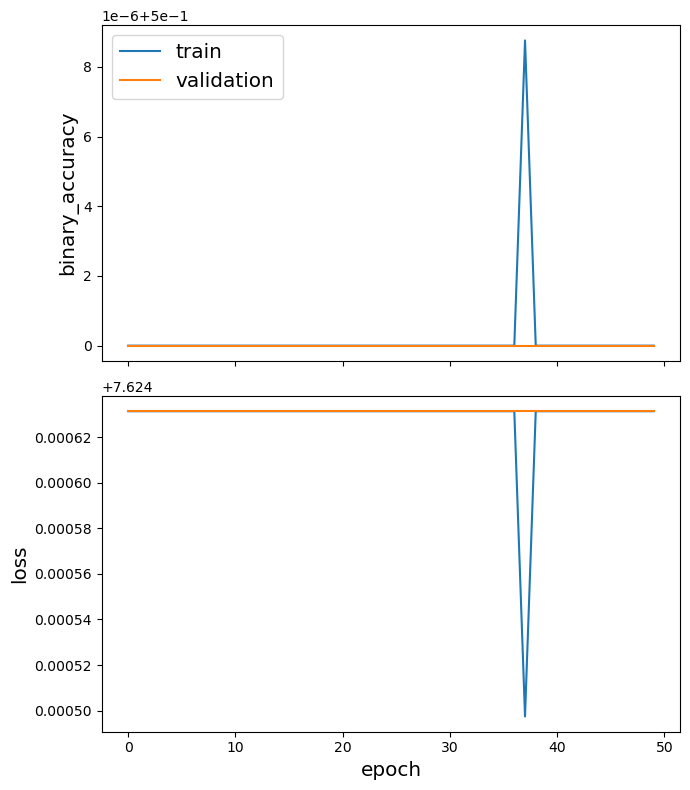

In [ ]:
sg.utils.plot_history(history)

In [ ]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


1/1 [==============================] - 1s 786ms/step - loss: 7.6246 - binary_accuracy: 0.5000

Train Set Metrics of the trained model:
	loss: 7.6246
	binary_accuracy: 0.5000

Test Set Metrics of the trained model:
	loss: 7.6246
	binary_accuracy: 0.5000
